In [76]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from copy import deepcopy
tqdm.pandas()
from tqdm import tqdm_notebook as tqdm
import time
import torch
from torch import nn
import itertools
import joblib
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import normalize
import gc
import requests
from torch.nn import SmoothL1Loss
from sklearn.model_selection import train_test_split
gc.collect()

exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

def set_seed(seed = 42):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    return seed
seed = set_seed(seed = 42)

C:\Users\ricky\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# load data

In [77]:
官方指認欄位 = ['2','6','10','12','13','15','18','19','21','22','25','26','36','37','39','48']
X_pca = joblib.load('../model/X_pca_for_knn.pkl')
df_groupby_chid_preprocessed = pd.read_feather('../data/df_groupby_chid_preprocessed.feather')
print(X_pca.shape,df_groupby_chid_preprocessed.shape)

(500000, 100) (500000, 148)


In [78]:
df = pd.read_feather('../data/2021玉山人工智慧公開挑戰賽冬季賽訓練資料集.feather')
df = df.loc[df.dt >= 12] # 取最近12個月資料
test_data = pd.read_feather('../data/需預測的顧客名單及提交檔案範例.feather')
display(df.head())
display(test_data.head())

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
13188928,12.0,10115966.0,15,1.0,9678.450445,1.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188938,12.0,10115966.0,18,1.0,9624.614033,1.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188944,12.0,10115966.0,25,1.0,2338.181448,1.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188946,12.0,10115966.0,26,2.0,16627.150110,2.0,0.0,0.0,0.0,1.00,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0
13188957,12.0,10115966.0,37,13.0,18485.113446,3.0,10.0,0.0,0.0,0.27,...,1.0,4.0,15.0,1.0,1.0,30.0,133000.939458,0.0,5.0,1.0


,chid,top1,top2,top3
0,10128239,18,10,6
1,10077943,48,22,6
2,10277876,22,10,39
3,10364842,37,19,13
4,10392717,2,36,26


# help functions

In [79]:
def chid2answer(chid): #chid到answer的映射
    a = df.loc[df['chid']==chid,'shop_tag'].value_counts().to_frame()
    a['在指認欄位'] = False
    a.loc[list(set(a.index)&set(官方指認欄位)),'在指認欄位'] = True #有交集的部份做記號
    answer = a[a['在指認欄位']==True].index.tolist()[:3] # 取有交集的部份前三名返回
    return answer

def get_values_counts(chid:int)->dict:
    '''
    chid到shop_tag之value_counts的映射
    '''
    n_class = 49
    d = dict(zip([str(i) for i in range(1,n_class)]+['other'],[0 for _ in range(n_class)]))
    frame = df.loc[df.chid==chid,'shop_tag'].value_counts()
    for shop_tag,counts in zip(frame.index,frame.values):
        d[shop_tag] = counts
    assert len(d.keys()) == n_class
    return d

def get_probs(value_counts:dict)->np.array:
    '''
    將value_counts(字典)轉成機率向量(np.array)
    '''
    n_class = 49
    counts = np.array(list(value_counts.values()))
    probs = counts / np.sum(counts)
    assert len(probs) == n_class
    return probs.tolist()

def adjust(x):
    a = torch.tensor([*range(len(x))]).reshape(-1,1)
    b = x.argmax(axis=1).reshape(-1,1)
    idx = torch.cat([a,b],dim=1)
    x[idx[:, 0], idx[:, 1]] = 0.0
    x /= x.sum(dim=1).reshape(-1,1)
    return x

def initial_h0(probs:np.array,remain)->torch.FloatTensor:
    '''
    初始化rnn的隱變量h0
    '''
    probs = torch.FloatTensor(probs).clone() # 轉成tensor
    if 3-remain == 0: #如果規則完全找不到任何shop_tag,remain=3
        hx = torch.zeros((probs.shape[0],49)) # "全零"初始化
        return hx
    else:
        for _ in range(3-remain): #例如剩下一個則3-1=2,做兩次括號內動作(找出第一名的機率的idx然後把它歸0剩下的歸一化)
            hx = adjust(probs)
        return hx

def probs2shoptag(probs,answer):
    官方指認欄位 = ['2','6','10','12','13','15','18','19','21','22','25','26','36','37','39','48']
    probs = dict(zip([ str(i) for i in range(1,49)]+['other'],probs.ravel().detach().numpy())) # 概率tensor轉換成概率字典
    probs = dict((k,probs[k]) for k in probs.keys() if k not in answer) # 將answer裡面已經有的濾掉(保留不在answer裡的)
    probs = dict((k,probs[k]) for k in probs.keys() if k in 官方指認欄位) # 將官方欄位裡面沒有的濾掉(保留在官方指定欄位的)
    shop_tag = max(probs,key=probs.get) # 取得概率字典中概率最大value(機率)對應的key(shop_tag)
    return shop_tag


# Y

In [80]:
idx_list = []
chid_list = test_data.loc[idx_list,'chid'].values.tolist()
for idx in tqdm(test_data.sample(500,random_state=seed).index.tolist()):
    answer = chid2answer(test_data.loc[idx,'chid'])
    if len(answer) == 3:
        idx_list.append(idx)
Y = torch.FloatTensor(test_data.loc[idx_list,'chid'].progress_apply(lambda chid:get_probs(get_values_counts(chid))).tolist())
print(Y.shape)
Y[0]

C:\Users\ricky\AppData\Local\Temp/ipykernel_16244/789838116.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(test_data.sample(500,random_state=seed).index.tolist()):


  2%|▏         | 7/380 [00:00<00:06, 61.57it/s]

100%|██████████| 380/380 [00:07<00:00, 51.90it/s]

torch.Size([380, 49])


tensor([0.0000, 0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1818, 0.0303, 0.0000, 0.0000, 0.0000, 0.0909, 0.3939, 0.0303, 0.1212,
        0.0303, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0606, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])

# X

In [81]:
X_pca = joblib.load('../model/X_pca_for_knn.pkl')[idx_list]
X_pca = torch.FloatTensor(X_pca)
print(X_pca.shape)
X_pca[0]

torch.Size([380, 100])


tensor([-1.6332e+00,  9.0545e-03, -1.0140e+00,  4.3550e+00, -1.7651e+00,
        -8.5587e-01, -1.9024e-01, -2.2905e+00,  2.3728e-02, -1.0820e-01,
         1.5173e-01, -1.0652e+00, -5.2777e-01, -4.3207e-01, -1.1028e-01,
        -7.7571e-01,  5.4544e-01, -3.5338e-01,  2.3715e-01,  3.1433e-01,
         9.6921e-02, -2.4594e+00, -6.2733e-01,  1.7855e+00, -9.3818e-02,
        -7.0888e-01,  1.1093e+00,  7.8211e-02,  1.8381e-02, -1.1325e+00,
         9.7349e-01, -3.2835e-01, -1.3693e+00,  1.4367e+00, -6.2182e-02,
         7.4944e-01,  6.5275e-01,  5.0727e-01, -6.3567e-01, -3.1819e-01,
        -1.2062e+00, -1.1418e+00,  1.5680e-01,  2.5214e-01, -2.3176e-01,
         1.5719e-01, -2.7729e-01,  1.5682e-02, -1.1049e-01,  3.2408e-01,
        -2.2430e-01, -8.3480e-02, -4.5862e-02, -2.0913e-01, -2.4418e-01,
         7.2761e-04,  4.1447e-02,  1.3467e-01, -1.0717e-01, -2.1765e-02,
        -3.3931e-02,  2.8161e-02,  8.0549e-03,  8.2429e-02,  2.8586e-02,
         1.5299e-02,  5.9053e-02,  1.7095e-02, -5.2

# define model

In [82]:
class R2D2(nn.Module):
  def __init__(self,input_size,output_size,hidden_size):
    super().__init__()
    self.l1 = nn.Linear(input_size,hidden_size) #layer1線性層
    self.l2 = nn.Linear(hidden_size,output_size) #layer2線性層
  def forward(self,x):
    features =  torch.tanh(self.l1(x)) #將x再經過layer1配激勵函數抽取有用的特徵稱之為features
    logits = self.l2(features) # 將features丟入layer2輸出logits
    logits = nn.Dropout(p=0.2)(logits) # 防止over fitting
    return torch.softmax(logits,dim=1) # 將logits輸出轉換成機率(softmax)
rnn = R2D2(X_pca.shape[1],Y.shape[1],Y.shape[1])
rnn

R2D2(
  (l1): Linear(in_features=100, out_features=49, bias=True)
  (l2): Linear(in_features=49, out_features=49, bias=True)
)

# forward test

In [83]:
rnn(X_pca)

tensor([[0.0205, 0.0173, 0.0205,  ..., 0.0205, 0.0101, 0.0205],
        [0.0223, 0.0181, 0.0111,  ..., 0.0191, 0.0179, 0.0107],
        [0.0258, 0.0194, 0.0194,  ..., 0.0194, 0.0196, 0.0366],
        ...,
        [0.0244, 0.0584, 0.0181,  ..., 0.0087, 0.0381, 0.0080],
        [0.0176, 0.0217, 0.0357,  ..., 0.0167, 0.0234, 0.0204],
        [0.0188, 0.0188, 0.0188,  ..., 0.0172, 0.0188, 0.0153]],
       grad_fn=<SoftmaxBackward>)

# train test split

In [84]:
train_idx ,test_idx = train_test_split([*range(len(X_pca))],test_size=0.5)

In [85]:
x_train,x_test = X_pca[train_idx],X_pca[test_idx]
y_train,y_test = Y[train_idx],Y[test_idx]

# train

In [86]:
def step(idx_list,x,y,model,mode='train'):
    # 切換兩種模式
    if mode == 'train':
        model.train()
    if mode == 'eval':
        model.eval()
    optimizer = MADGRAD(model.parameters(),lr=1e-3) # 優化器
    answer_dict = {} # 初始化answer字典
    loss_dict = {} # 初始化loss字典
    for i,idx in enumerate(idx_list): # 對樣本作遍歷
        answer = [] # 初始化answer列表
        total_loss = 0 # 初始化總損失
        for _ in range(3): # 預測top1,top2,top3
            probs = rnn(x) # nn forward
            total_loss += SmoothL1Loss()(probs,y) # 計算loss並加入total_loss
            shop_tag = probs2shoptag(probs[i],answer) # 預測這個樣本的shop_tag
            answer.append(shop_tag) # 將shop_tag併入answer
        answer_dict[idx] = answer # 紀錄answer
        loss_dict[idx] = total_loss # 紀錄loss
        if (mode in ['train']) & (i%2==0): # 更新網路參數(如果是訓練模式)
            total_loss.backward()# 利用反向傳播算法求梯度
            optimizer.step() # 執行梯度下降更新神經網路參數
            optimizer.zero_grad() # 梯度歸零
    return answer_dict,loss_dict # 返回答案和loss

# look loss

C:\Users\ricky\AppData\Local\Temp/ipykernel_16244/203329622.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(100)):


epoch:0 train loss:0.8941814303398132 test loss:1.0015372037887573
epoch:10 train loss:0.5024821758270264 test loss:1.0319737195968628
epoch:20 train loss:0.3764210641384125 test loss:1.1838901042938232
epoch:30 train loss:0.3141210377216339 test loss:1.2284317016601562
epoch:40 train loss:0.28752973675727844 test loss:1.2426831722259521
epoch:50 train loss:0.2680579721927643 test loss:1.2517718076705933
epoch:60 train loss:0.2531372010707855 test loss:1.277053952217102
epoch:70 train loss:0.24493290483951569 test loss:1.3035249710083008
epoch:80 train loss:0.23493856191635132 test loss:1.3307043313980103
epoch:90 train loss:0.23203063011169434 test loss:1.3714083433151245



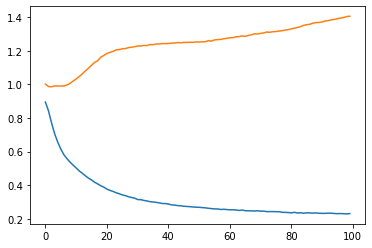

In [87]:
loss_history = {'train':[],'test':[]}
best_loss = np.inf
for epoch in tqdm(range(100)):
    # train step
    train_pred,train_loss = step(train_idx,x_train,y_train,rnn,mode='train')
    loss_history['train'].append(np.sum(list(train_loss.values())))
    # test step
    test_pred,test_loss = step(test_idx,x_test,y_test,rnn,mode='eval')
    loss_history['test'].append(np.sum(list(test_loss.values())))
    if loss_history['test'][-1] < best_loss:
        best_loss = loss_history['test'][-1]
        best_model = deepcopy(rnn.eval())
        #print('best model saved')
    # print information
    if epoch % 10 == 0:
        a = epoch
        b = loss_history['train'][-1]
        c = loss_history['test'][-1]
        print(f'epoch:{a} train loss:{b} test loss:{c}')
# plot loss_history
plt.plot(loss_history['train'],label='train')
plt.plot(loss_history['test'],label='test')
plt.show()

# use best model

In [88]:
train_pred,train_loss = step(train_idx,x_train,y_train,best_model,mode='eval')
test_pred,test_loss = step(test_idx,x_test,y_test,best_model,mode='eval')

# metrics

In [89]:
def metrics(pred_dict,test_data,idx_list):
    a,b = [],[]
    ground_true = dict(zip(idx_list,test_data.loc[idx_list,'chid'].progress_apply(chid2answer).values.tolist()))
    for y_pred,y_true in tqdm(zip(pred_dict.values(),ground_true.values())):
        a.append(y_pred),b.append(y_true)
    a,b = pd.DataFrame(a).values,pd.DataFrame(b).values
    return np.equal(a,b).sum()/(a.shape[0]*a.shape[1])

In [90]:
print('訓練集正確率:',metrics(train_pred,test_data,[idx_list[i] for i in train_idx]))
print('測試集正確率:',metrics(test_pred,test_data,[idx_list[i] for i in test_idx]))

100%|██████████| 190/190 [00:03<00:00, 51.39it/s]
C:\Users\ricky\AppData\Local\Temp/ipykernel_16244/1991256331.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for y_pred,y_true in tqdm(zip(pred_dict.values(),ground_true.values())):


  4%|▎         | 7/190 [00:00<00:02, 61.03it/s]


訓練集正確率: 0.531578947368421


100%|██████████| 190/190 [00:03<00:00, 50.95it/s]
C:\Users\ricky\AppData\Local\Temp/ipykernel_16244/1991256331.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for y_pred,y_true in tqdm(zip(pred_dict.values(),ground_true.values())):



測試集正確率: 0.1
